# SFDR ESG Factors:
### Carbon Efficiency & Governance Effectiveness
# Article 8 Themes:
### Climate Change Mitigation, Environmental Protection, & Social Justice

In [1]:
#from IPython.display import Javascript
#display(Javascript('IPython.notebook.execute_cells_below()'))

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as st
import math
import matplotlib.pyplot as plt

### Data ETL

In [3]:
inputFileName = "SFDR_ESG_Factors.xlsx"
dfPNL = pd.read_excel(inputFileName,"PNL")
dfXL_Port = pd.read_excel(inputFileName,"XL_Port")
dfXL_Bench = pd.read_excel(inputFileName,"XL_Bench")
dfMSCI_Port = pd.read_excel(inputFileName,"MSCI_Port")
dfMSCI_Bench = pd.read_excel(inputFileName,"MSCI_Bench")

In [4]:
listCI_Corp = ['CARBON_EMISSIONS_SCOPE_12_INTEN']
listCI_Sov = ['CARBON_GOVERNMENT_CO2_INTENSITY_GDP']
listGE_Corp = ['AUDIT_COMMITTEE_INDEP_PCT','BOARD_INDEP_PCT','PCT_WOMEN', 
               'BUSINESS_ETHICS_THEME_SCORE','CORRUPTION_INST_MGMT_SCORE','BUS_ETHICS_WHISTLEBLOW_SD']
listGE_Sov = ['GOVERNMENT_RAW_EFFECTIVENESS','GOVERNMENT_RAW_REG_QUAL', 
              'GOVERNMENT_RAW_CORR_PERC_INDEX','GOVERNMENT_RAW_CONT_OF_CORR']
listCI = listCI_Corp + listCI_Sov
listGE = listGE_Corp + listGE_Sov
listFactors = listCI + listGE
listCorp = listCI_Corp + listGE_Corp
listSov = listCI_Sov + listGE_Sov

In [5]:
dictCCM = {
    "CONTR_CLIMATE_CHNG_M":"No",
    "CBN_PROG_REDUC_OP_EMISS_M":"Yes",
    "CBN_RENEW_ENER_USE_M":"Yes",
    "CBN_REG_ENV_AUDITS_M":"Yes",
    "EXEC_OVERSIGHT_ENV_M":"Yes",
    "CBN_TARGET_QUANT_REDUC_M":"Yes",
    "BUS_EXP_CARBON_INTENSIVE_OPS_M":"No",
    "CBN_EXP_STRANDED_FF_M":"No",
    "GEO_EXP_CARBON_REGULATION_M":"No",
    "GEO_EXP_CLIMATE_CHG_VUL_REGIONS_M":"No",
    "BUS_EXP_CARBON_INTEN_SUPPLY_CHAIN_M":"No",
}

In [6]:
dictEP = {
    "ENVIRONMENT_CONTROVERSY_FLAG":"Green",
    "ENVIRONMENT_CLIMATE_FLAG":"Green",
    "ENVIRONMENT_LAND_FLAG":"Green",
    "ENVIRONMENT_WASTE_FLAG":"Green",
    "ENVIRONMENT_OTHER_FLAG":"Green",
    "ENVIRONMENT_TOXIC_FLAG":"Green",
    "ENVIRONMENT_SUPPLY_FLAG":"Green",
    "ENVIRONMENT_WATER_FLAG":"Green",
    "CONTR_ENV_IMPACT_M":"No",
    "CONTR_ENV_INVESTMENT_M":"No",
    "CONTR_IMPACT_ECOSYSTEMS_M":"No",
    "CONTR_RAW_MATERIAL_M":"No",
    "CONTR_WATER_M":"No",
    "EXEC_OVERSIGHT_WATER_M":"Yes",
    "BUS_EXP_LAND_ECO_DISTURBANCE_M":"No",
    "BUS_EXP_WATER_INTENSIVE_OPS_M":"No",
    "GEO_EXP_FRAGILE_ECO_M":"No",
    "GEO_EXP_WATER_STRESS_REGIONS_M":"No",
    "WATER_OP_REDUCT_TARGETS_M":"Yes",
    "WATER_RISK_MONITORING_M":"Yes",
    "WATER_REDUCT_PROG_OPERATIONS_M":"Yes",
    "WATER_REDUCT_PROG_SUPPLYCHAIN_M":"Yes",
}

In [7]:
dictSJ = {
    "HUMAN_RIGHTS_LOCAL_COMM_FLAG":"Green",
    "HUMAN_RIGHTS_CIVIL_LIBERTIES_FLAG":"Green",
    "HUMAN_RIGHTS_CONTROVERSY_FLAG":"Green",
    "HUMAN_RIGHTS_CONCERNS_FLAG":"Green",
    "HUMAN_RIGHTS_OTHER_FLAG":"Green",
    "LABOR_RIGHTS_CHILD_FLAG":"Green",
    "LABOR_RIGHTS_CBA_FLAG":"Green",
    "LABOR_RIGHTS_CONTROVERSY_FLAG":"Green",
    "LABOR_RIGHTS_DIVERSITY_FLAG":"Green",
    "LABOR_RIGHTS_EMP_HS_FLAG":"Green",
    "LABOR_RIGHTS_MGT_REL_FLAG":"Green",
    "LABOR_RIGHTS_OTHER_FLAG":"Green",
    "LABOR_RIGHTS_LABOR_STAND_FLAG":"Green",
    "SOCIAL_CONTROVERSY_FLAG":"Green",
}
indUNGC = "UNGC_COMPLIANCE"

In [8]:
sid = 'Client_ID'
wgt = 'Portfolio_Weight'
dfPort = dfMSCI_Port[[sid, wgt]+listFactors]
dfBench = dfMSCI_Bench[[sid, wgt]+listFactors]
dfPortCCM = dfMSCI_Port[[sid, wgt]+list(dictCCM.keys())]
dfBenchCCM = dfMSCI_Bench[[sid, wgt]+list(dictCCM.keys())]
dfPortEP = dfMSCI_Port[[sid, wgt]+list(dictEP.keys())]
dfBenchEP = dfMSCI_Bench[[sid, wgt]+list(dictEP.keys())]
dfPortSJ = dfMSCI_Port[[sid, wgt]+list(dictSJ.keys())]
dfBenchSJ = dfMSCI_Bench[[sid, wgt]+list(dictSJ.keys())]
dfPortUNGC = dfMSCI_Port[[sid, wgt, indUNGC]]
dfBenchUNGC = dfMSCI_Bench[[sid, wgt, indUNGC]]

In [9]:
isin = 'ID_ISIN'
industry = 'Ab Strat Industry'
country = 'Country of Risk Code'
ticker = 'Ticker'
#rating = 'URV ESG Score'
rating = 'Loomis ESG Score'
listHeaders = dfPort.columns.to_list()
listHeaders += [industry, country, ticker, rating]
xScoreCI = []
xScoreGE = []
for factor in listCI:
    xScoreCI += ["xScore_"+factor]
for factor in listGE:
    xScoreGE += ["xScore_"+factor]
listHeaders += xScoreCI
listHeaders += xScoreGE
dfPort = dfPort.reindex(columns = listHeaders)
dfBench = dfBench.reindex(columns = listHeaders)

### SFDR Feature Normalization

In [10]:
dictUniv = {}
for factor in listFactors:
    df = dfMSCI_Bench[factor][dfMSCI_Bench[factor].notna()]
    dictUniv[factor] = df

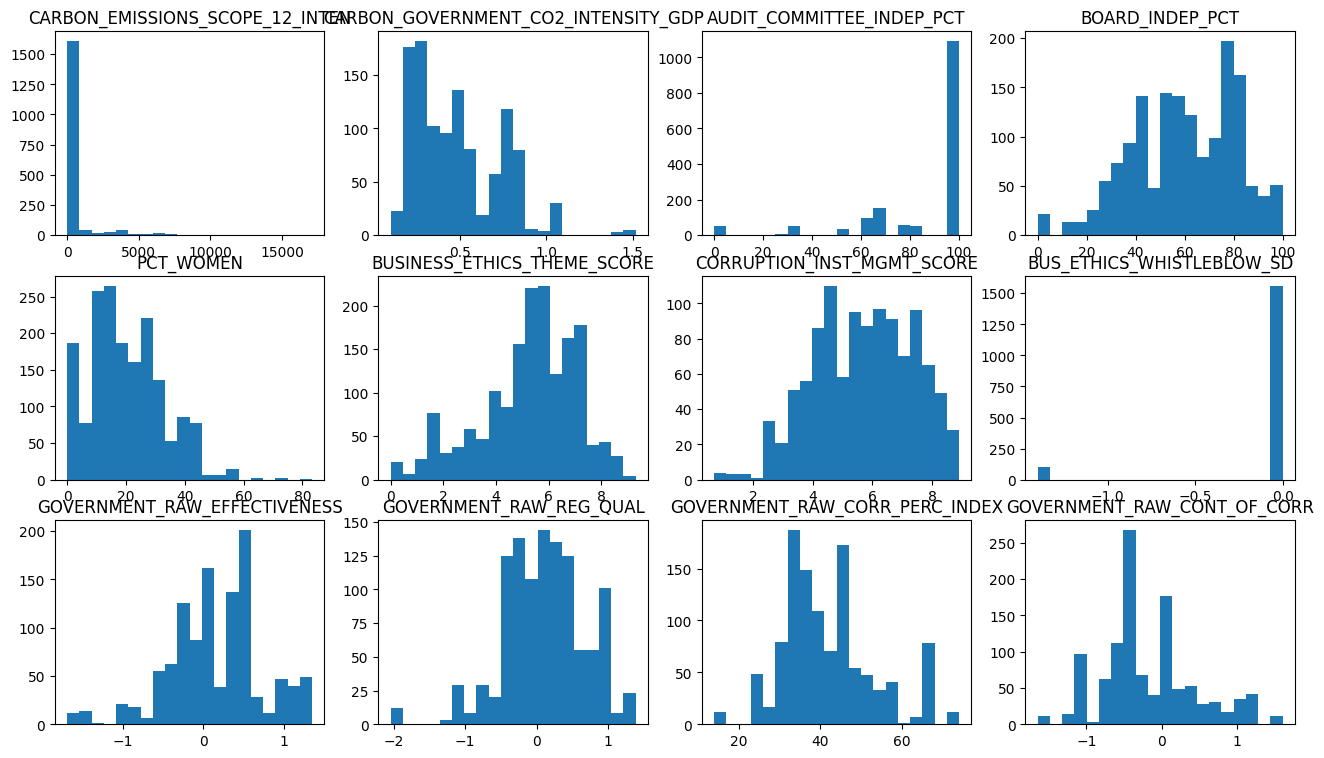

In [11]:
j = int(math.ceil(np.sqrt(len(listFactors))))
i = int(math.ceil(len(listFactors)/j))
fig, axs = plt.subplots(nrows=i, ncols=j, figsize=(16,12/j*i))
n_bins = 20
kk = 0
for ii in range(i):
    for jj in range(j):
        if kk < len(listFactors):
            axs[ii,jj].hist(dictUniv[listFactors[kk]], bins=n_bins)
            axs[ii,jj].title.set_text(listFactors[kk])
            kk += 1

In [12]:
for factor in listCI:
    dictUniv.update({factor : np.log(dictUniv[factor]+1)})
for factor in listGE:
    if factor == "PCT_WOMEN":
        dictUniv.update({factor : abs(50-dictUniv[factor])})
    else:
        dictUniv.update({factor : -dictUniv[factor]})

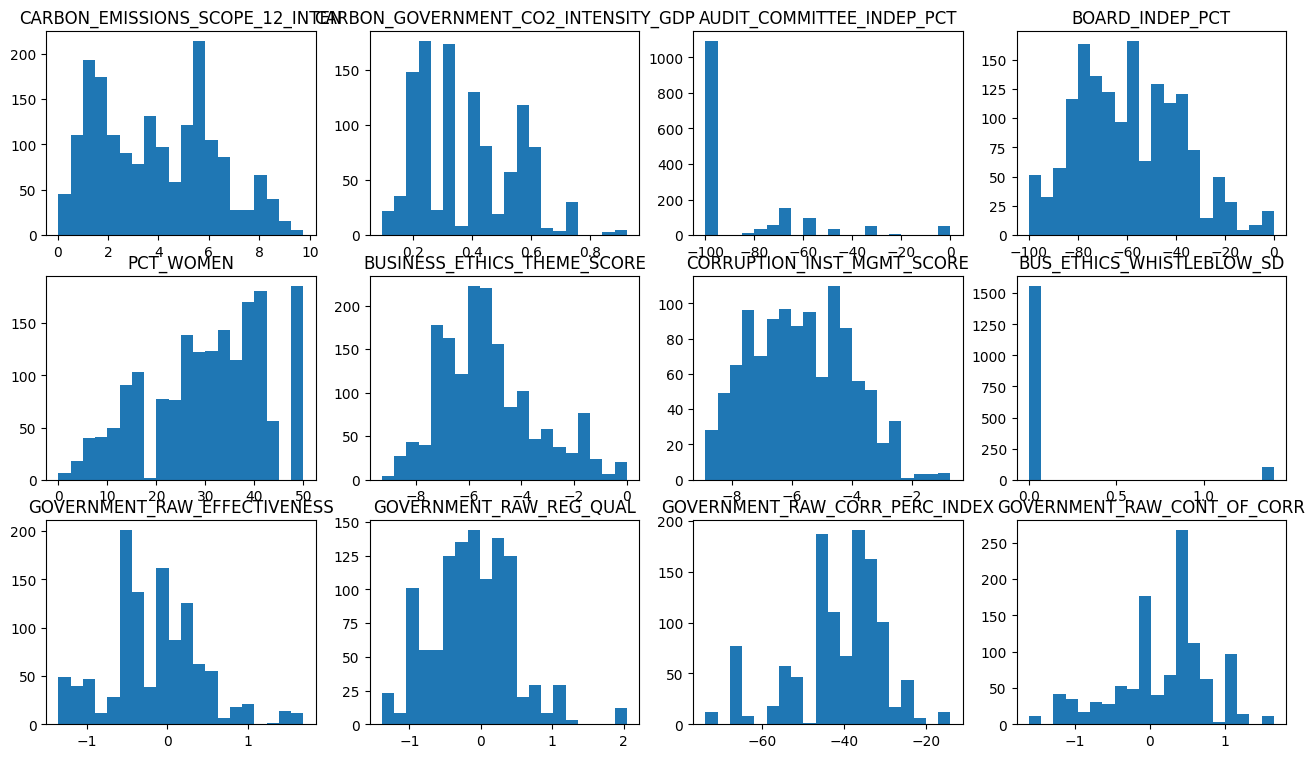

In [13]:
j = int(math.ceil(np.sqrt(len(listFactors))))
i = int(math.ceil(len(listFactors)/j))
fig, axs = plt.subplots(nrows=i, ncols=j, figsize=(16,12/j*i))
n_bins = 20
kk = 0
for ii in range(i):
    for jj in range(j):
        if kk < len(listFactors):
            axs[ii,jj].hist(dictUniv[listFactors[kk]], bins=n_bins)
            axs[ii,jj].title.set_text(listFactors[kk])
            kk += 1

### Data Synthesizing

In [14]:
for factor in listFactors:
    df = dictUniv[factor].to_frame()
    df[sid] = None
    df[industry] = None
    df[country] = None
    for i in dictUniv[factor].index.tolist():
        tempISIN = dfMSCI_Bench[sid].iat[i]
        df[sid].at[i] = tempISIN
        df[industry].at[i] = dfXL_Bench[industry][dfXL_Bench[isin]==tempISIN].values[0]
        df[country].at[i] = dfXL_Bench[country][dfXL_Bench[isin]==tempISIN].values[0]
    dictUniv.update({factor : df})

In [15]:
dictIndustry = {}
for factor in listFactors:
    df = dictUniv[factor].groupby(industry).agg({factor: ['mean', 'std', 'count']})
    df.columns = df.columns.droplevel(0)
    df = df.reset_index()
    dictIndustry[factor] = df

### Feature Engineering

In [16]:
for i in dfPort.index.tolist():
    tempISIN = dfPort[sid].iat[i]
    tempIndustry = dfXL_Port[industry][dfXL_Port[isin]==tempISIN].values[0]
    dfPort.loc[i, industry] = tempIndustry
    dfPort.loc[i, country] = dfXL_Port[country][dfXL_Port[isin]==tempISIN].values[0]
    dfPort.loc[i, ticker] = dfXL_Port[ticker][dfXL_Port[isin]==tempISIN].values[0]
    dfPort.loc[i, rating] = dfXL_Port[rating][dfXL_Port[isin]==tempISIN].values[0]
    for factor in listCI:
        dfPort.loc[i, factor] = np.log(dfPort.loc[i, factor]+1)
    for factor in listGE:
        if factor == "PCT_WOMEN":
            dfPort.loc[i, factor] = abs(50-dfPort.loc[i, factor])
        else:
            dfPort.loc[i, factor] = -dfPort.loc[i, factor]
    for factor in listFactors:
        try:
            tempMean = dictIndustry[factor]['mean'][dictIndustry[factor][industry]==tempIndustry].values[0]
            tempStd = dictIndustry[factor]['std'][dictIndustry[factor][industry]==tempIndustry].values[0]
            tempZScore = (dfPort[factor][dfPort[sid]==tempISIN].values[0] - tempMean)/tempStd
            dfPort.loc[i, "xScore_"+factor] = st.norm.cdf(tempZScore) * 9 + 1
        except IndexError as e:
            pass

C:\Users\tqiu\AppData\Local\Temp\ipykernel_58696\3632100656.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'BANKING' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  dfPort.loc[i, industry] = tempIndustry
C:\Users\tqiu\AppData\Local\Temp\ipykernel_58696\3632100656.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'TR' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  dfPort.loc[i, country] = dfXL_Port[country][dfXL_Port[isin]==tempISIN].values[0]
C:\Users\tqiu\AppData\Local\Temp\ipykernel_58696\3632100656.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'AKBNK' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df

In [17]:
for i in dfBench.index.tolist():
    tempISIN = dfBench[sid].iat[i]
    try:
        tempIndustry = dfXL_Bench[industry][dfXL_Bench[isin]==tempISIN].values[0]
    except IndexError as e:
        continue
    dfBench.loc[i, industry] = tempIndustry
    dfBench.loc[i, country] = dfXL_Bench[country][dfXL_Bench[isin]==tempISIN].values[0]
    dfBench.loc[i, ticker] = dfXL_Bench[ticker][dfXL_Bench[isin]==tempISIN].values[0]
    dfBench.loc[i, rating] = dfXL_Bench[rating][dfXL_Bench[isin]==tempISIN].values[0]
    for factor in listCI:
        dfBench.loc[i, factor] = np.log(dfBench.loc[i, factor]+1)
    for factor in listGE:
        if factor == "PCT_WOMEN":
            dfBench.loc[i, factor] = abs(50-dfBench.loc[i, factor])
        else:
            dfBench.loc[i, factor] = -dfBench.loc[i, factor]
    for factor in listFactors:
        try:
            tempMean = dictIndustry[factor]['mean'][dictIndustry[factor][industry]==tempIndustry].values[0]
            tempStd = dictIndustry[factor]['std'][dictIndustry[factor][industry]==tempIndustry].values[0]
            tempZScore = (dfBench[factor][dfBench[sid]==tempISIN].values[0] - tempMean)/tempStd
            dfBench.loc[i, "xScore_"+factor] = st.norm.cdf(tempZScore) * 9 + 1
        except IndexError as e:
            pass

C:\Users\tqiu\AppData\Local\Temp\ipykernel_58696\3387969961.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'TSY/AGY/SOV/SUPRA' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  dfBench.loc[i, industry] = tempIndustry
C:\Users\tqiu\AppData\Local\Temp\ipykernel_58696\3387969961.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'CN' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  dfBench.loc[i, country] = dfXL_Bench[country][dfXL_Bench[isin]==tempISIN].values[0]
C:\Users\tqiu\AppData\Local\Temp\ipykernel_58696\3387969961.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'CNOOC' has dtype incompatible with float64, please explicitly cast to a compatible dty

In [18]:
scoreCI = 'xScore_Carbon_Efficiency'
scoreGE = 'xScore_Governance_Effectiveness'
dfPort[scoreCI] = dfPort[xScoreCI].mean(axis=1)
dfPort[scoreGE] = dfPort[xScoreGE].mean(axis=1)
dfBench[scoreCI] = dfBench[xScoreCI].mean(axis=1)
dfBench[scoreGE] = dfBench[xScoreGE].mean(axis=1)

### Fallback Logics

In [19]:
dfPort[[sid, wgt, industry, country, ticker, scoreCI, scoreGE]][dfPort[scoreCI].isna()]

,Client_ID,Portfolio_Weight,Ab Strat Industry,Country of Risk Code,Ticker,xScore_Carbon_Efficiency,xScore_Governance_Effectiveness
24,US900148AF49,0.005470,BANKING,TR,GARAN,NaN,7.020248
25,US900148AG22,0.011958,BANKING,TR,GARAN,NaN,7.020248
122,US69377FAB22,0.004509,TSY/AGY/SOV/SUPRA,ID,FRIDPT,NaN,NaN
132,XS1709535097,0.005021,TSY/AGY/SOV/SUPRA,AE,ADNOUH,NaN,NaN
133,XS2412048550,0.006064,ELECTRIC,CZ,ENGPRO,NaN,NaN
138,XS2057842176,0.006390,ELECTRIC,IN,ARENRJ,NaN,NaN
140,US36321PAE07,0.004530,ENERGY,AE,ADGLXY,NaN,NaN
142,US00109AAB35,0.004286,ELECTRIC,PA,AES,NaN,NaN
144,USV3855MAA54,0.006677,TSY/AGY/SOV/SUPRA,IN,GRNKEN,NaN,NaN
145,USG2588BAA29,0.005930,COMMUNICATIONS,GT,COMCEL,NaN,NaN


In [20]:
for i in dfPort.index.tolist():
    if pd.isna(dfPort.loc[i, scoreCI]):
        try:
            tempCountry = dfPort.loc[i, country]
            j = dfBench[listCI_Sov][dfBench[country]==tempCountry].dropna().index[0]
            dfPort.loc[i, scoreCI] = dfBench.loc[j, scoreCI]
        except IndexError as e:
            pass
print("Count:", dfPort[sid][dfPort[scoreCI].isna()].count())
print("Weight:", dfPort[wgt][dfPort[scoreCI].isna()].sum())

Count: 0
Weight: 0.0


In [21]:
dfPort[[sid, wgt, industry, country, ticker, scoreCI, scoreGE]][dfPort[scoreGE].isna()]

,Client_ID,Portfolio_Weight,Ab Strat Industry,Country of Risk Code,Ticker,xScore_Carbon_Efficiency,xScore_Governance_Effectiveness
122,US69377FAB22,0.004509,TSY/AGY/SOV/SUPRA,ID,FRIDPT,5.975002,NaN
132,XS1709535097,0.005021,TSY/AGY/SOV/SUPRA,AE,ADNOUH,4.718344,NaN
133,XS2412048550,0.006064,ELECTRIC,CZ,ENGPRO,2.813054,NaN
138,XS2057842176,0.006390,ELECTRIC,IN,ARENRJ,9.261880,NaN
140,US36321PAE07,0.004530,ENERGY,AE,ADGLXY,4.718344,NaN
142,US00109AAB35,0.004286,ELECTRIC,PA,AES,1.838157,NaN
144,USV3855MAA54,0.006677,TSY/AGY/SOV/SUPRA,IN,GRNKEN,9.261880,NaN
145,USG2588BAA29,0.005930,COMMUNICATIONS,GT,COMCEL,2.118170,NaN
147,USG95448AA75,0.007109,BASIC_INDUSTRY,TR,WESODA,4.520836,NaN
150,US63890CAB00,0.010000,TSY/AGY/SOV/SUPRA,UZ,NAVOIM,9.996175,NaN


In [22]:
for i in dfPort.index.tolist():
    if pd.isna(dfPort.loc[i, scoreGE]):
        try:
            tempCountry = dfPort.loc[i, country]
            j = dfBench[listGE_Sov[0]][dfBench[country]==tempCountry].dropna().index[0]
            dfPort.loc[i, scoreGE] = dfBench.loc[j, scoreGE]
        except IndexError as e:
            pass
print("Count:", dfPort[sid][dfPort[scoreGE].isna()].count())
print("Weight:", dfPort[wgt][dfPort[scoreGE].isna()].sum())

Count: 0
Weight: 0.0


In [23]:
print("Count:", dfBench[sid][dfBench[scoreCI].isna()].count())
print("Weight:", dfBench[wgt][dfBench[scoreCI].isna()].sum())
dfBench[[sid, wgt, industry, country, ticker, scoreCI, scoreGE]][dfBench[scoreCI].isna()]

Count: 312
Weight: 0.06224116


,Client_ID,Portfolio_Weight,Ab Strat Industry,Country of Risk Code,Ticker,xScore_Carbon_Efficiency,xScore_Governance_Effectiveness
4,XS2904540692,0.000193,BANKING,ID,BBKPIJ,NaN,6.478932
155,XS2744911830,0.000169,BANKING,TR,TEBNK,NaN,NaN
156,XS2888538431,0.000127,BANKING,TR,TEBNK,NaN,NaN
323,USP19189AE26,0.000214,CONSUMER_NON_CYCLICAL,PE,CSOLNO,NaN,NaN
337,XS2901898291,0.000000,MBS_PASSTHROUGH,KR,SHNHAN,NaN,NaN
...,...,...,...,...,...,...,...
3202,US71654QAY89,0.000138,TSY/AGY/SOV/SUPRA,MX,PEMEX,NaN,NaN
3203,USL56608AM12,0.000245,CONSUMER_NON_CYCLICAL,US,JBSSBZ,NaN,NaN
3204,USP2550MAA29,0.000125,ELECTRIC,CL,CHIPEC,NaN,NaN
3205,USP7354FAG11,0.000018,COMMUNICATIONS,BR,OIBRBZ,NaN,NaN


In [24]:
for i in dfBench.index.tolist():
    if pd.isna(dfBench.loc[i, scoreCI]):
        try:
            tempCountry = dfBench.loc[i, country]
            j = dfBench[listCI_Sov][dfBench[country]==tempCountry].dropna().index[0]
            dfBench.loc[i, scoreCI] = dfBench.loc[j, scoreCI]
        except IndexError as e:
            pass
print("Count:", dfBench[sid][dfBench[scoreCI].isna()].count())
print("Weight:", dfBench[wgt][dfBench[scoreCI].isna()].sum())

Count: 24
Weight: 0.005157469999999999


In [25]:
print("Count:", dfBench[sid][dfBench[scoreGE].isna()].count())
print("Weight:", dfBench[wgt][dfBench[scoreGE].isna()].sum())
dfBench[[sid, wgt, industry, country, ticker, scoreCI, scoreGE]][dfBench[scoreGE].isna()]

Count: 334
Weight: 0.06381603


,Client_ID,Portfolio_Weight,Ab Strat Industry,Country of Risk Code,Ticker,xScore_Carbon_Efficiency,xScore_Governance_Effectiveness
155,XS2744911830,0.000169,BANKING,TR,TEBNK,4.520836,NaN
156,XS2888538431,0.000127,BANKING,TR,TEBNK,4.520836,NaN
194,XS2921409756,0.000191,BANKING,PH,PNBPM,9.655147,NaN
323,USP19189AE26,0.000214,CONSUMER_NON_CYCLICAL,PE,CSOLNO,2.204555,NaN
337,XS2901898291,0.000000,MBS_PASSTHROUGH,KR,SHNHAN,3.624639,NaN
...,...,...,...,...,...,...,...
3202,US71654QAY89,0.000138,TSY/AGY/SOV/SUPRA,MX,PEMEX,2.797501,NaN
3203,USL56608AM12,0.000245,CONSUMER_NON_CYCLICAL,US,JBSSBZ,NaN,NaN
3204,USP2550MAA29,0.000125,ELECTRIC,CL,CHIPEC,2.595075,NaN
3205,USP7354FAG11,0.000018,COMMUNICATIONS,BR,OIBRBZ,2.227640,NaN


In [26]:
for i in dfBench.index.tolist():
    if pd.isna(dfBench.loc[i, scoreGE]):
        try:
            tempCountry = dfBench.loc[i, country]
            j = dfBench[listGE_Sov[0]][dfBench[country]==tempCountry].dropna().index[0]
            dfBench.loc[i, scoreGE] = dfBench.loc[j, scoreGE]
        except IndexError as e:
            pass
print("Count:", dfBench[sid][dfBench[scoreGE].isna()].count())
print("Weight:", dfBench[wgt][dfBench[scoreGE].isna()].sum())

Count: 41
Weight: 0.00805699


### Article 8 Indicators

In [27]:
dfPort["xScore_UNGC_Compliance"] = dfPortUNGC[indUNGC].fillna("Not Rated")
dfBench["xScore_UNGC_Compliance"] = dfBenchUNGC[indUNGC].fillna("Not Rated")

In [28]:
def getCCMScore(x):
    if x >= 9:
        return "A"
    if x >= 8:
        return "B"
    if x >= 5:
        return "C"
    if x >= 3:
        return "D"
    if x < 0:
        return "NR"
    return "F"

df_nan = (dfPortCCM.fillna("Not Rated") == "Not Rated")
for indicator in list(dictCCM.keys()):
    dfPort["xScore_"+indicator] = (dfPortCCM[indicator].fillna("Not Rated") == dictCCM[indicator])
dfPort["xScore_Climate_Change_Mitigation"] = (dfPort[["xScore_"+ind for ind in list(dictCCM.keys())]].select_dtypes(include=['bool']).sum(axis=1) - df_nan[list(dictCCM.keys())].select_dtypes(include=['bool']).sum(axis=1)).map(getCCMScore)

df_nan = (dfBenchCCM.fillna("Not Rated") == "Not Rated")
for indicator in list(dictCCM.keys()):
    dfBench["xScore_"+indicator] = (dfBenchCCM[indicator].fillna("Not Rated") == dictCCM[indicator])
dfBench["xScore_Climate_Change_Mitigation"] = (dfBench[["xScore_"+ind for ind in list(dictCCM.keys())]].select_dtypes(include=['bool']).sum(axis=1) - df_nan[list(dictCCM.keys())].select_dtypes(include=['bool']).sum(axis=1)).map(getCCMScore)

In [29]:
def getEPScore(x):
    if x >= 19:
        return "A"
    if x >= 17:
        return "B"
    if x >= 11:
        return "C"
    if x >= 6:
        return "D"
    if x < 0:
        return "NR"
    return "F"

df_nan = (dfPortEP.fillna("Not Rated") == "Not Rated")
for indicator in list(dictEP.keys()):
    dfPort["xScore_"+indicator] = (dfPortEP[indicator].fillna("Not Rated") == dictEP[indicator])
dfPort["xScore_Environmental_Protection"] = (dfPort[["xScore_"+ind for ind in list(dictEP.keys())]].select_dtypes(include=['bool']).sum(axis=1) - df_nan[list(dictEP.keys())].select_dtypes(include=['bool']).sum(axis=1)).map(getEPScore)

df_nan = (dfBenchEP.fillna("Not Rated") == "Not Rated")
for indicator in list(dictEP.keys()):
    dfBench["xScore_"+indicator] = (dfBenchEP[indicator].fillna("Not Rated") == dictEP[indicator])
dfBench["xScore_Environmental_Protection"] = (dfBench[["xScore_"+ind for ind in list(dictEP.keys())]].select_dtypes(include=['bool']).sum(axis=1) - df_nan[list(dictEP.keys())].select_dtypes(include=['bool']).sum(axis=1)).map(getEPScore)

In [30]:
def getSJScore(x):
    if x >= 12:
        return "A"
    if x >= 11:
        return "B"
    if x >= 7:
        return "C"
    if x >= 4:
        return "D"
    if x < 0:
        return "NR"
    return "F"

df_nan = (dfPortSJ.fillna("Not Rated") == "Not Rated")
for indicator in list(dictSJ.keys()):
    dfPort["xScore_"+indicator] = (dfPortSJ[indicator].fillna("Not Rated") == dictSJ[indicator])
dfPort["xScore_Social_Justice"] = (dfPort[["xScore_"+ind for ind in list(dictSJ.keys())]].select_dtypes(include=['bool']).sum(axis=1) - df_nan[list(dictSJ.keys())].select_dtypes(include=['bool']).sum(axis=1)).map(getSJScore)

df_nan = (dfBenchSJ.fillna("Not Rated") == "Not Rated")
for indicator in list(dictSJ.keys()):
    dfBench["xScore_"+indicator] = (dfBenchSJ[indicator].fillna("Not Rated") == dictSJ[indicator])
dfBench["xScore_Social_Justice"] = (dfBench[["xScore_"+ind for ind in list(dictSJ.keys())]].select_dtypes(include=['bool']).sum(axis=1) - df_nan[list(dictSJ.keys())].select_dtypes(include=['bool']).sum(axis=1)).map(getSJScore)

### Results Interpretation

In [31]:
dfPort.to_csv('dfPort.csv')
dfBench.to_csv('dfBench.csv')

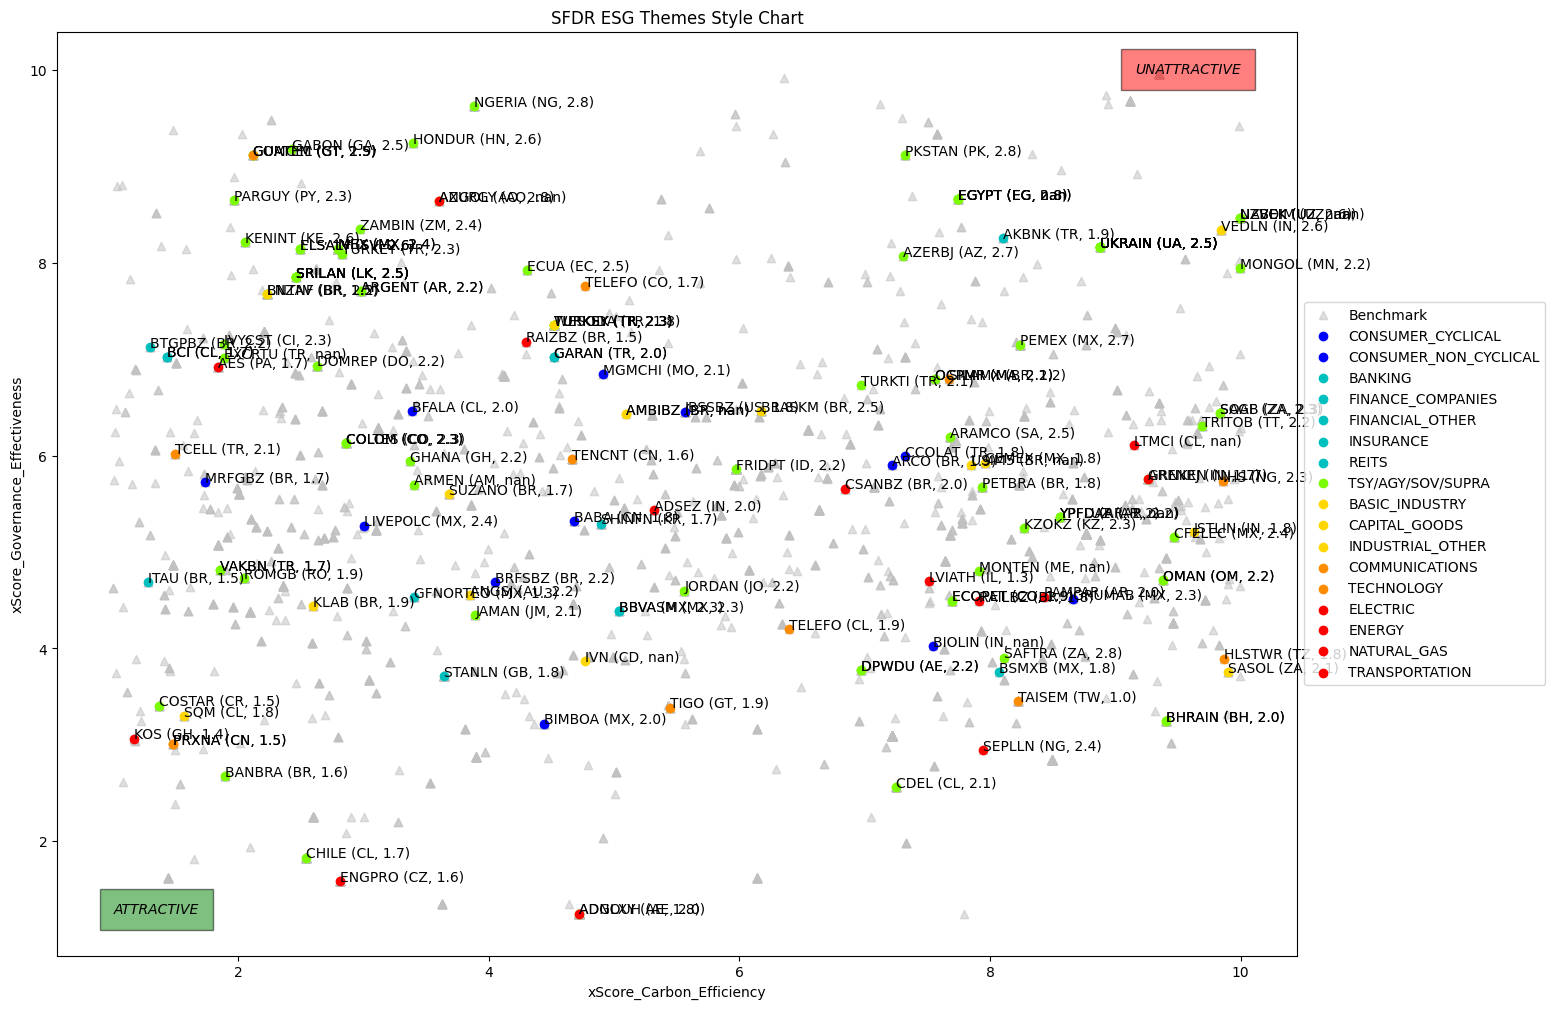

In [32]:
x_col = scoreCI
y_col = scoreGE
z_col = industry

r_col = country
s_col = rating
t_col = ticker

labels = ["CONSUMER_CYCLICAL", "CONSUMER_NON_CYCLICAL", 
           "BANKING", "FINANCE_COMPANIES", "FINANCIAL_OTHER", "INSURANCE", "REITS", 
           "TSY/AGY/SOV/SUPRA", 
           "BASIC_INDUSTRY", "CAPITAL_GOODS", "INDUSTRIAL_OTHER", 
           "COMMUNICATIONS", "TECHNOLOGY", 
           "ELECTRIC", "ENERGY", "NATURAL_GAS", "TRANSPORTATION"]
colors = ['b', 'b', 
          'c', 'c', 'c', 'c', 'c', 
          'lawngreen', 
          'gold', 'gold', 'gold', 
          'darkorange', 'darkorange', 
          'r', 'r', 'r', 'r']

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)

plt.scatter(dfBench[x_col], dfBench[y_col], marker='^', color='silver', label="Benchmark", alpha=0.5)

for i in range(len(labels)):
    plt.scatter(dfPort[x_col][dfPort[z_col]==labels[i]], dfPort[y_col][dfPort[z_col]==labels[i]], 
                marker='o', color=colors[i], label=labels[i])

ax.text(dfBench[x_col].max(), dfBench[y_col].max(), 'UNATTRACTIVE', style='italic', 
        bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10}, horizontalalignment='right')
ax.text(dfBench[x_col].min(), dfBench[y_col].min(), 'ATTRACTIVE', style='italic', 
        bbox={'facecolor': 'green', 'alpha': 0.5, 'pad': 10}, horizontalalignment='left')

plt.xlabel(x_col)
plt.ylabel(y_col)
plt.title('SFDR ESG Themes Style Chart')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

for i in dfPort.index:
    ax.annotate('%s (%s, %s)' % (dfPort[t_col][i], dfPort[r_col][i], dfPort[s_col][i].round(1)), 
                xy=(dfPort[x_col][i],dfPort[y_col][i]), textcoords='data')

fig.savefig('sfdr_theme_fig.png', format='png')